# Pryngles Tutorials: Quickstart

This is a basic tutorial to [pryngles](https://pypi.org/project/pryngles/).

Here we explore the basic capabilities of the packages.

> **Notes**: 
> - This tutorial works properly for 0.4.x <= versions <=0.6.x

## Install the package

Before running `Pryngles` you must be sure to install the latest version:

In [ ]:
!python -m pip install -U pryngles

## Google Colab users

If you are in Google Colab, run the following commands:

In [2]:
import matplotlib.pyplot as plt
RESOLUTION = 150
%matplotlib inline
plt.rcParams['figure.dpi'] = RESOLUTION

## Loading the package

The first thing you need to do is to load the package.  The `load_ext` and `autoreload` magics are useful if you update the package and want to 

In [1]:
%load_ext autoreload
%autoreload 2
import pryngles as pr
from pryngles.legacy import *
from pryngles import Consts
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating a planetary system

In order to create a planetary system you need first to create an object implementing all the required functionalities of the packages:

In [2]:
sys=pr.System()
S=sys.add(kind="Star",
          physics=dict(radius=Consts.rsun/sys.ul),
          optics=dict(limb_coeffs=[0.65])
         )
P=sys.add(kind="Planet",primary=S,
          orbit=dict(a=0.2,e=0.0),
          physics=dict(radius=Consts.rsaturn/sys.ul)
         )
R=sys.add(kind="Ring",primary=P,
          physics=dict(fi=1.5,fe=2.5,i=30*Consts.deg)
         )
O=sys.add(kind="Observer",
          optics=dict(lamb=90*Consts.deg,beta=90*Consts.deg)
         )
RP=sys.ensamble_system()

Let's see the planet:

<IPython.core.display.Javascript object>


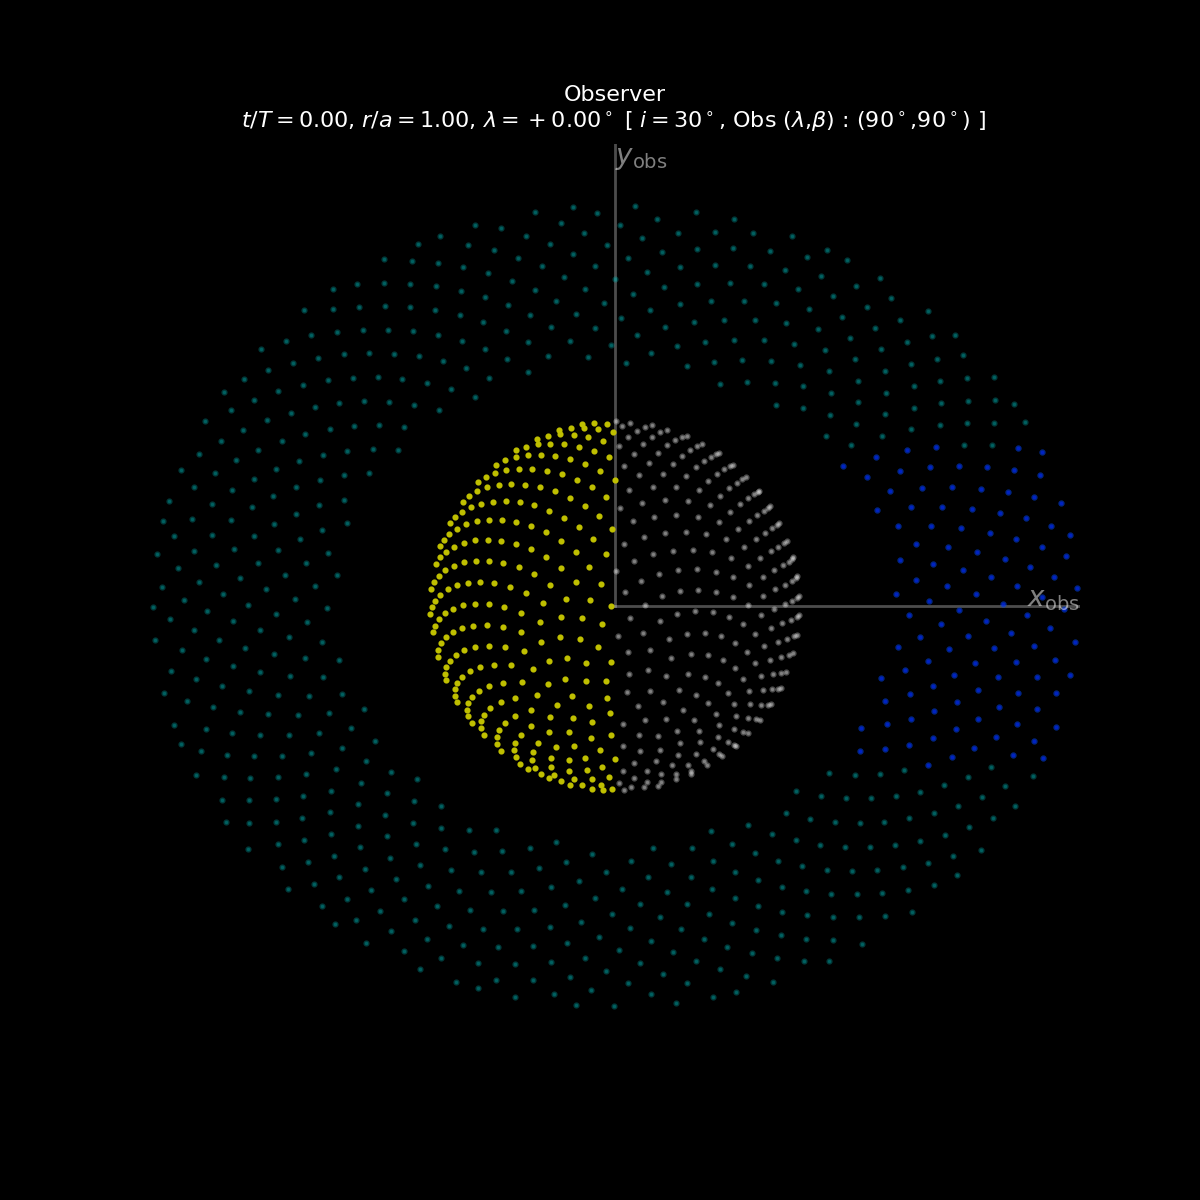

In [3]:
ecliptic,observer,star=RP.plotRingedPlanet(showfig=0)
observer

You may change stellar position:

In [4]:
RP.changeStellarPosition(45*Consts.deg)

Let's see the effect:

<IPython.core.display.Javascript object>


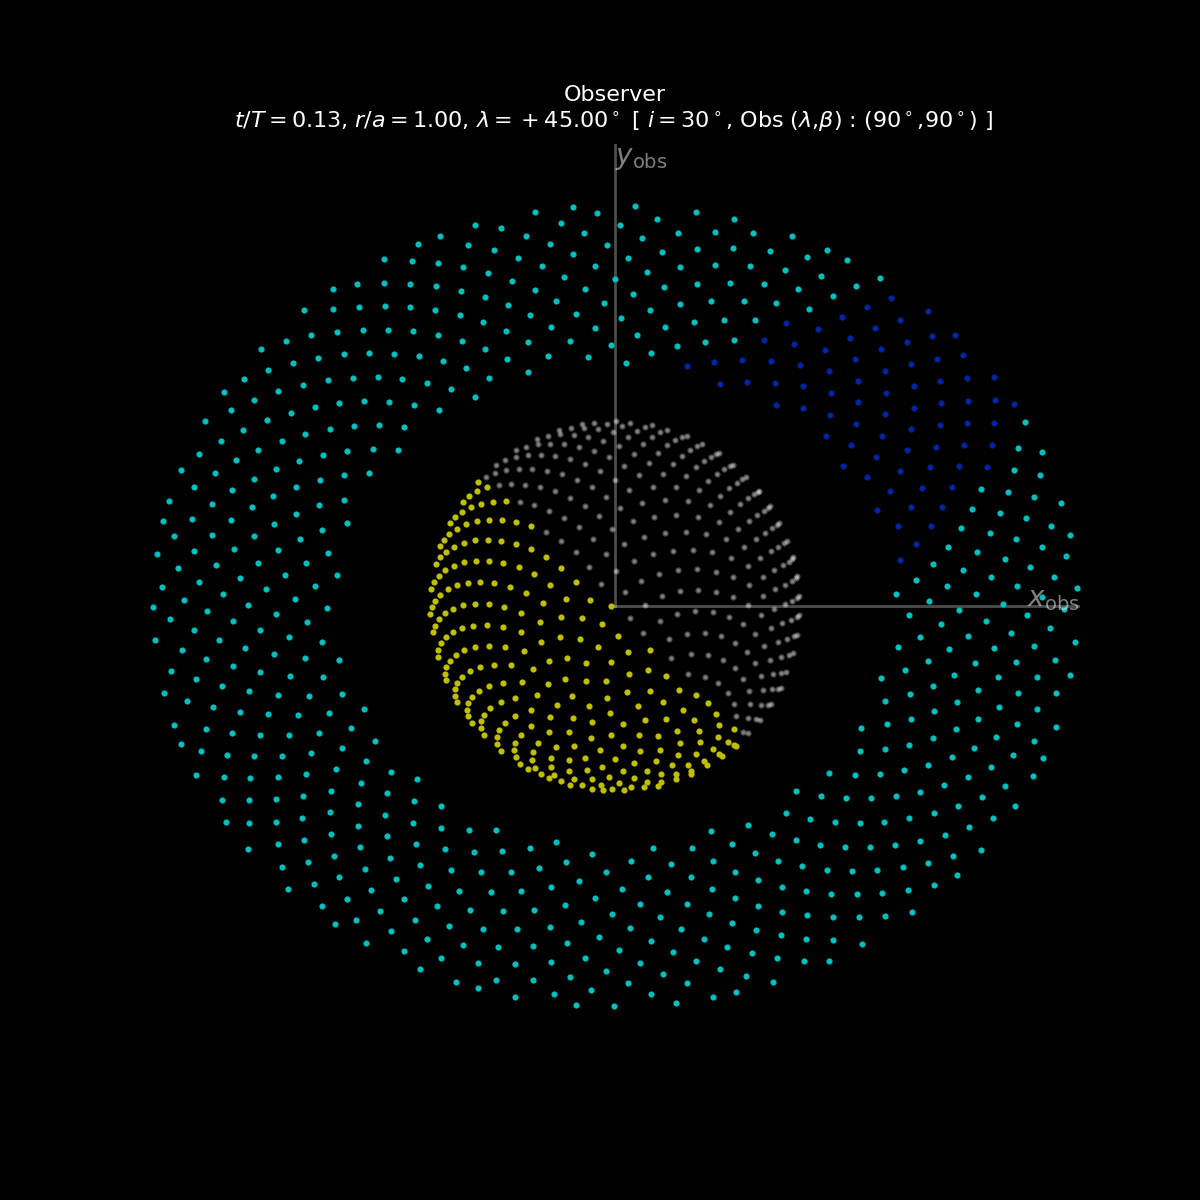

In [5]:
ecliptic,observer,star=RP.plotRingedPlanet(showfig=0)
observer

Please notice how the illuminated side of the planet and the shadow casted on the ring are now rotated.

To understand why we talk about *stellar position* see the following diagram:

![Stellar orientation](https://raw.githubusercontent.com/seap-udea/pryngles-public/master/gallery/orbit_ring_orientation.png)

As you see we consider that the star is who is actually orbiting the planet (this is a planeto-centric) model.

`fig1` (in the list of figures that `plotRingedPlanet` method produce) is a view in the *Ecliptic* {ecl} system of coordinates.

Actually we recognize other four systems of coordinates (see Figure below):

![System of coordinates in the model](https://raw.githubusercontent.com/seap-udea/pryngles-public/master/gallery/reference_frames.png)

Let's change the position of the observer.  This is done by specifying the spherical coordinates in the `{ecl}` system (ecliptical longitude and latitude).  For instance:

In [6]:
RP.changeObserver([90.0*Consts.deg,0.0*Consts.deg])

This coordinates places the observer on the x-y plane of the ecliptic (orbital plane) and looking towards the -y axis.  Let's see what the observer sees:

<IPython.core.display.Javascript object>


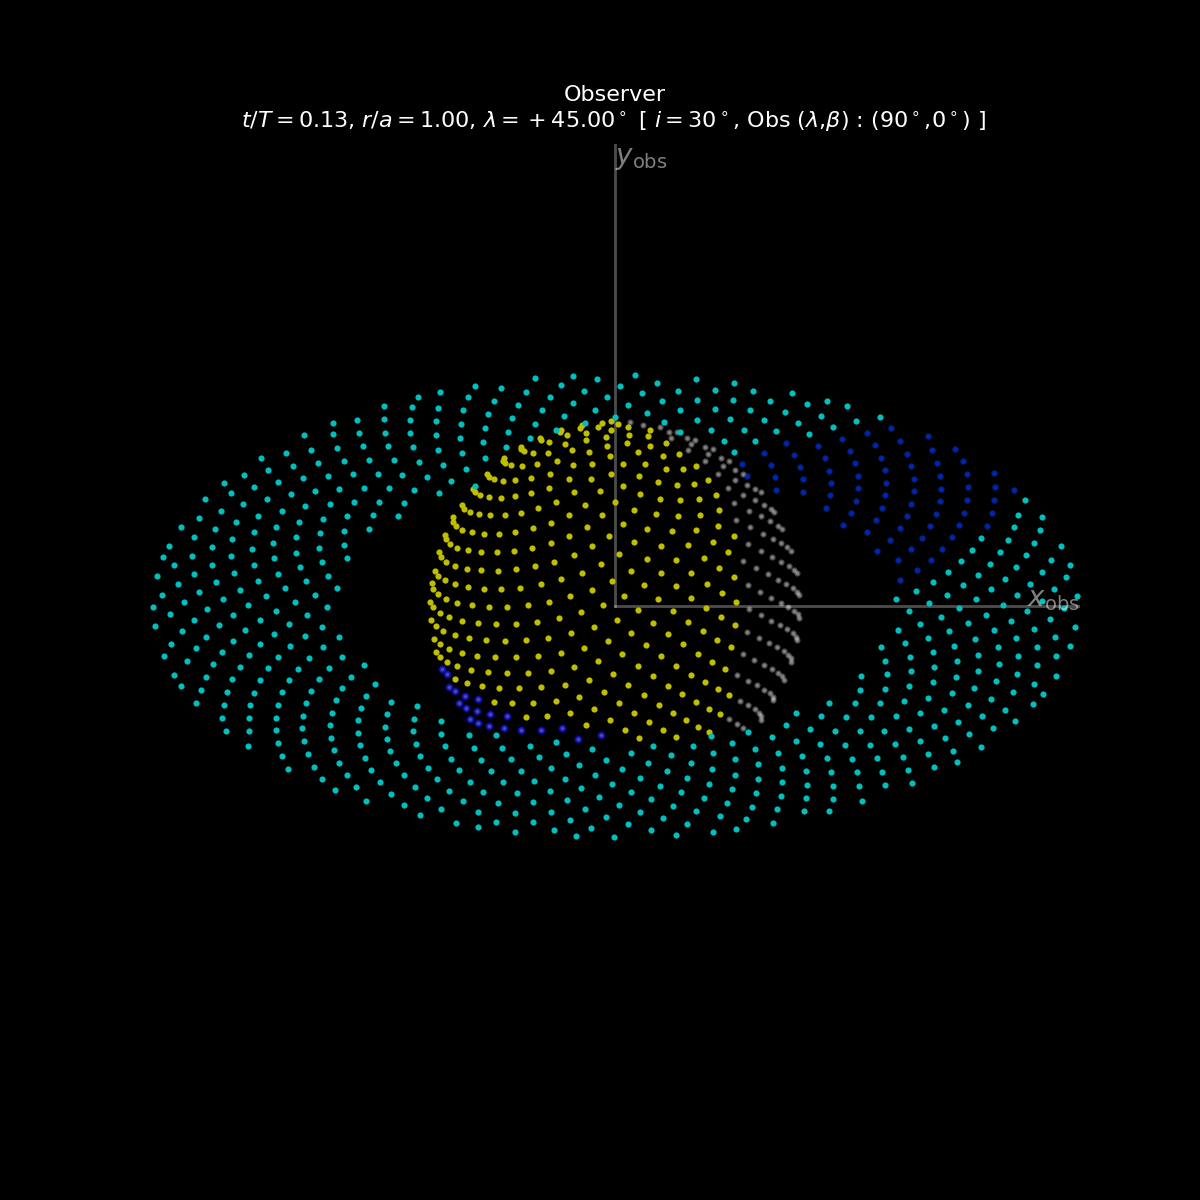

In [7]:
ecliptic,observer,star=RP.plotRingedPlanet(showfig=0)
observer

Oh yeah! You may probably realize that in this view the model simulates the fact that the observer cannot see part of the ring because the planet is in the middle.  This is not only a graphical attribute of the model, it is very omportant at calculating the light-curve of the system.

You may play around with `P.changeObserver` to understand the meaning of both angles in the argument (remember, they are the ecliptic longitude and latitude of the observer) and with `P.changeStellarPosition`.

<IPython.core.display.Javascript object>


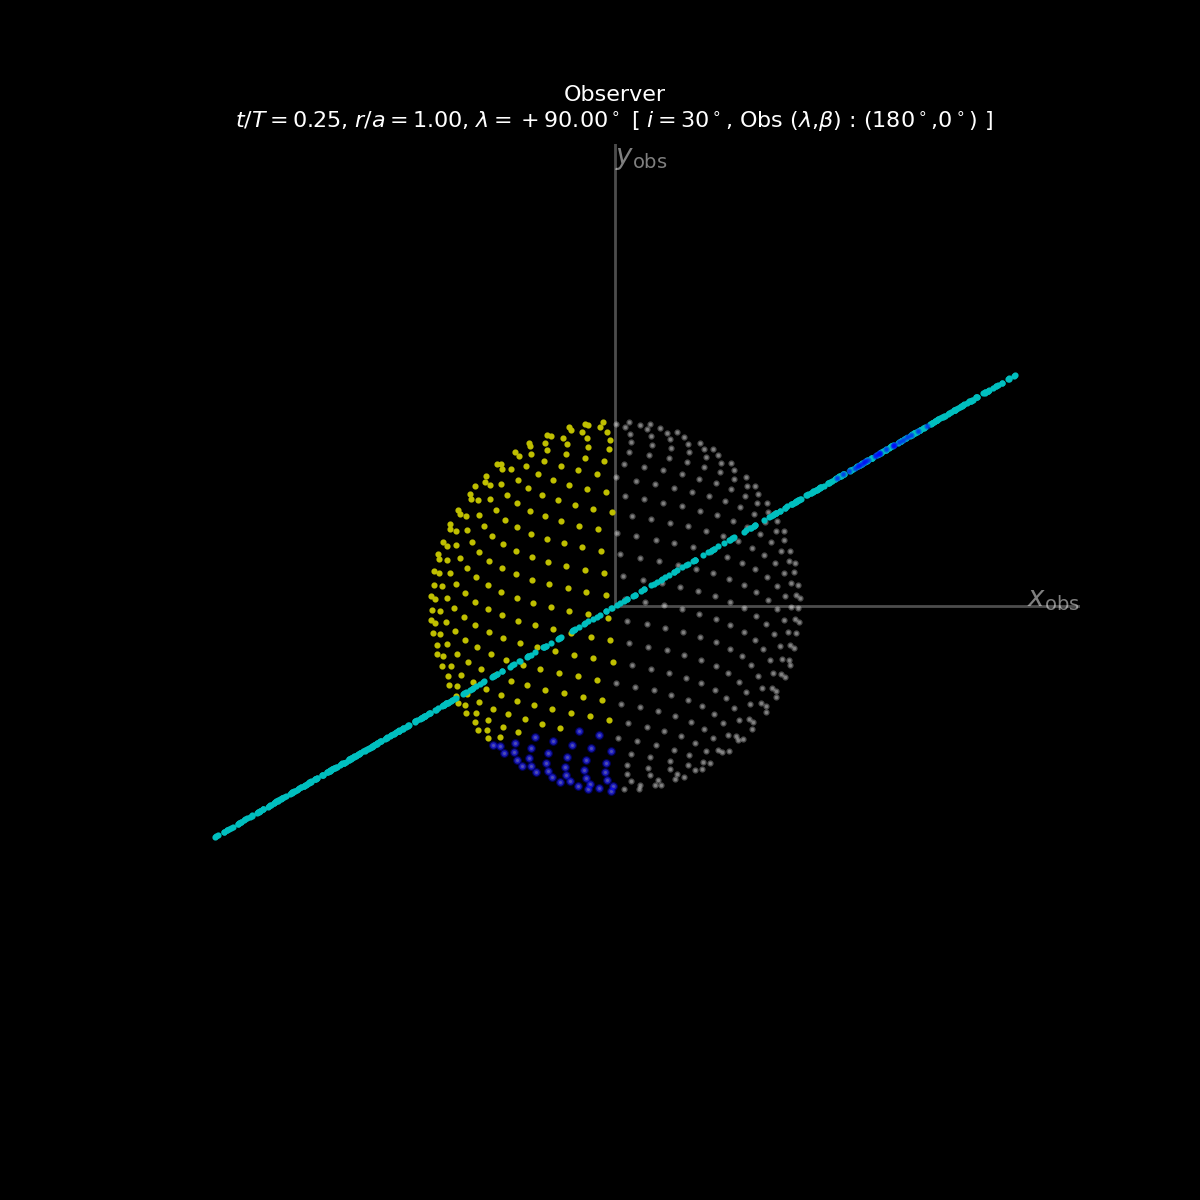

In [8]:
RP.changeObserver([180.0*Consts.deg,0.0,Consts.deg])
RP.changeStellarPosition(90*Consts.deg)
ecliptic,observer,star=RP.plotRingedPlanet(showfig=0)
observer

## Transits and occultations

Of course in certain star-planet-observer configurations you may see the planet occulting behind the stellar disk or transiting in front of it.  See for instance:

<IPython.core.display.Javascript object>


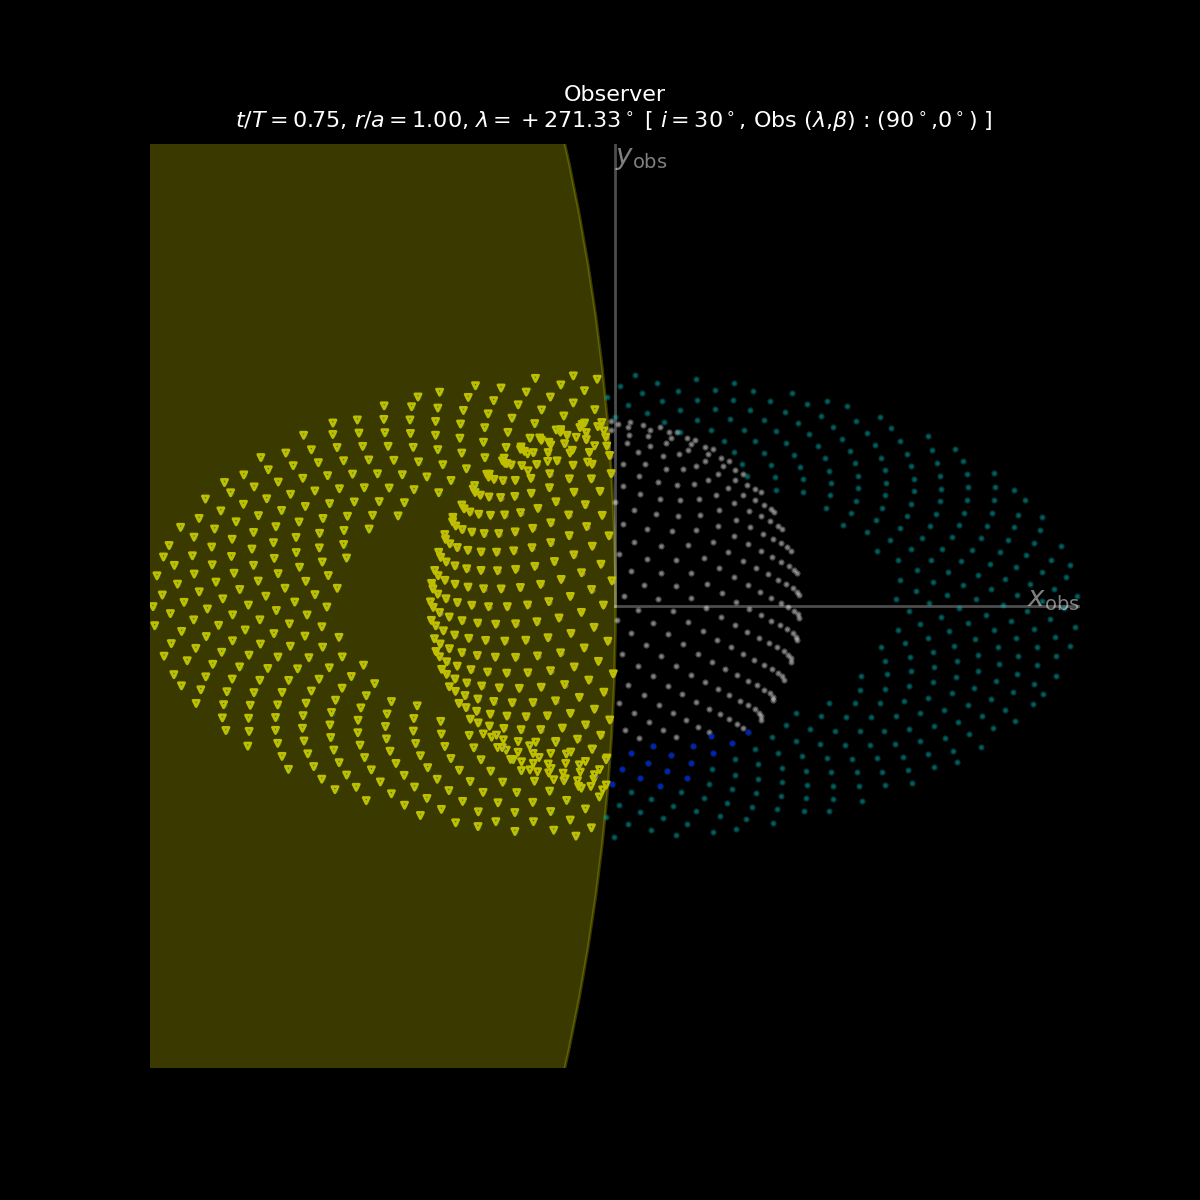

In [9]:
RP.changeObserver([90.0*Consts.deg,0.0*Consts.deg])
RP.changeStellarPosition(270*Consts.deg+RP.thetas)
ecliptic,observer,star=RP.plotRingedPlanet(showfig=0,showstar=1)
observer

In this case the planet is transiting the star.  And in this case is being occulted by it:

<IPython.core.display.Javascript object>


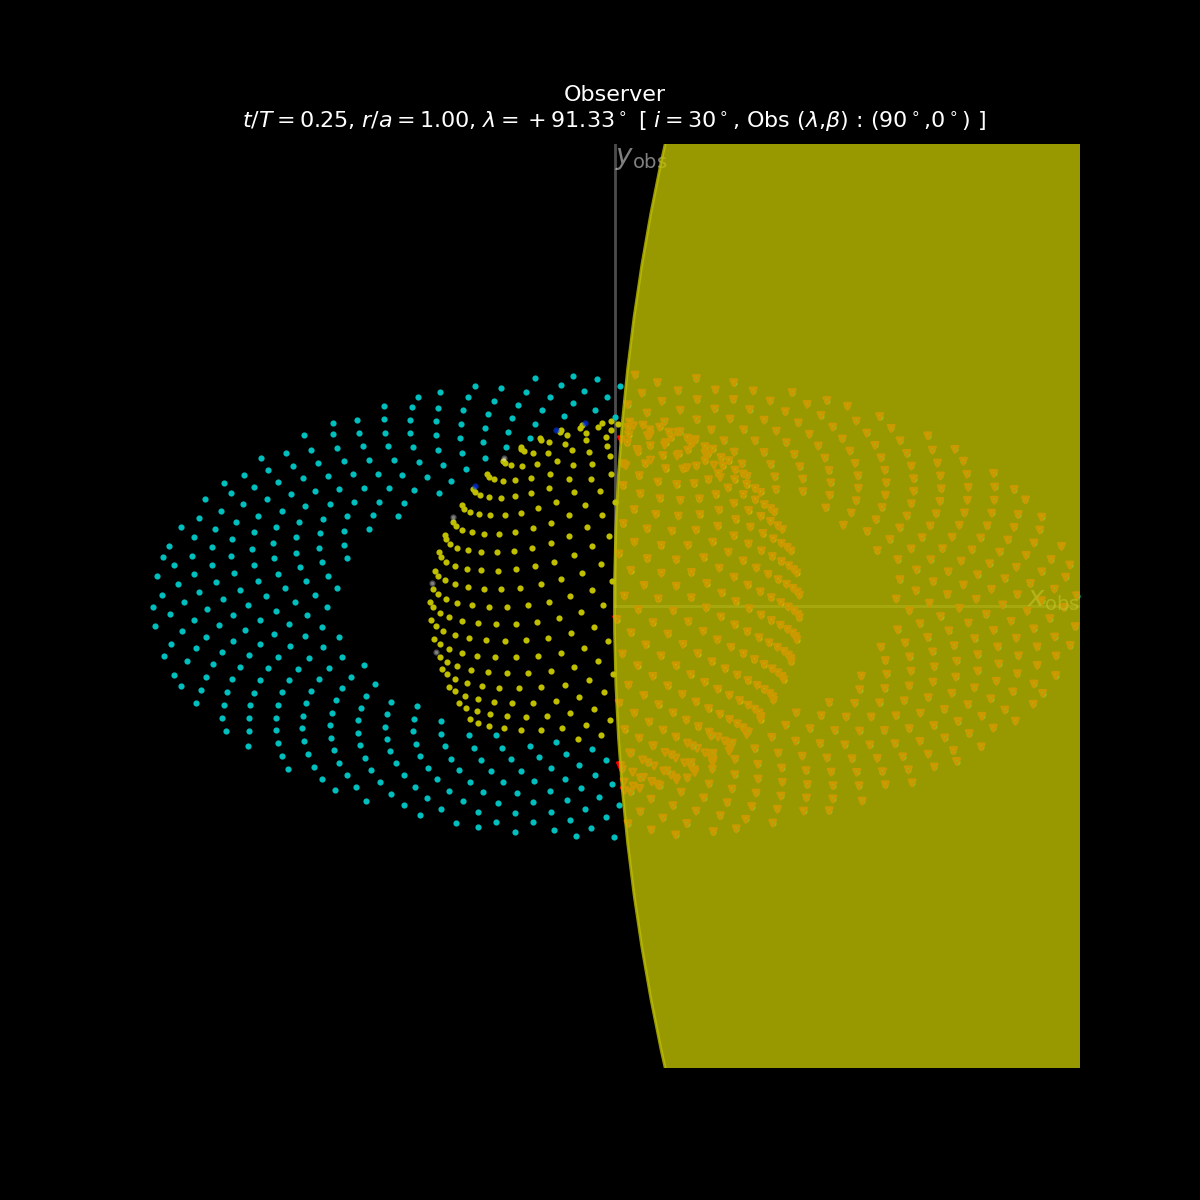

In [10]:
RP.changeObserver([90.0*Consts.deg,0.0*Consts.deg])
RP.changeStellarPosition(90*Consts.deg+RP.thetas)
ecliptic,observer,star=RP.plotRingedPlanet(showfig=0,showstar=1)
observer

Notice that in both the ecliptic longitude of the star is slightly (a few degrees) different thant that of the observer (in the occultation case) or that of 180+ecliptic longitude of the observer (in the case of transit).

## Light curve 

The units in the horizontal axis are not very undertandable.  They are radians and we are used to time since middle transit.  On the other hand we are used to see T as a negative quantity.  

This is how we can make this plot similar to what we have been used to:

<IPython.core.display.Javascript object>


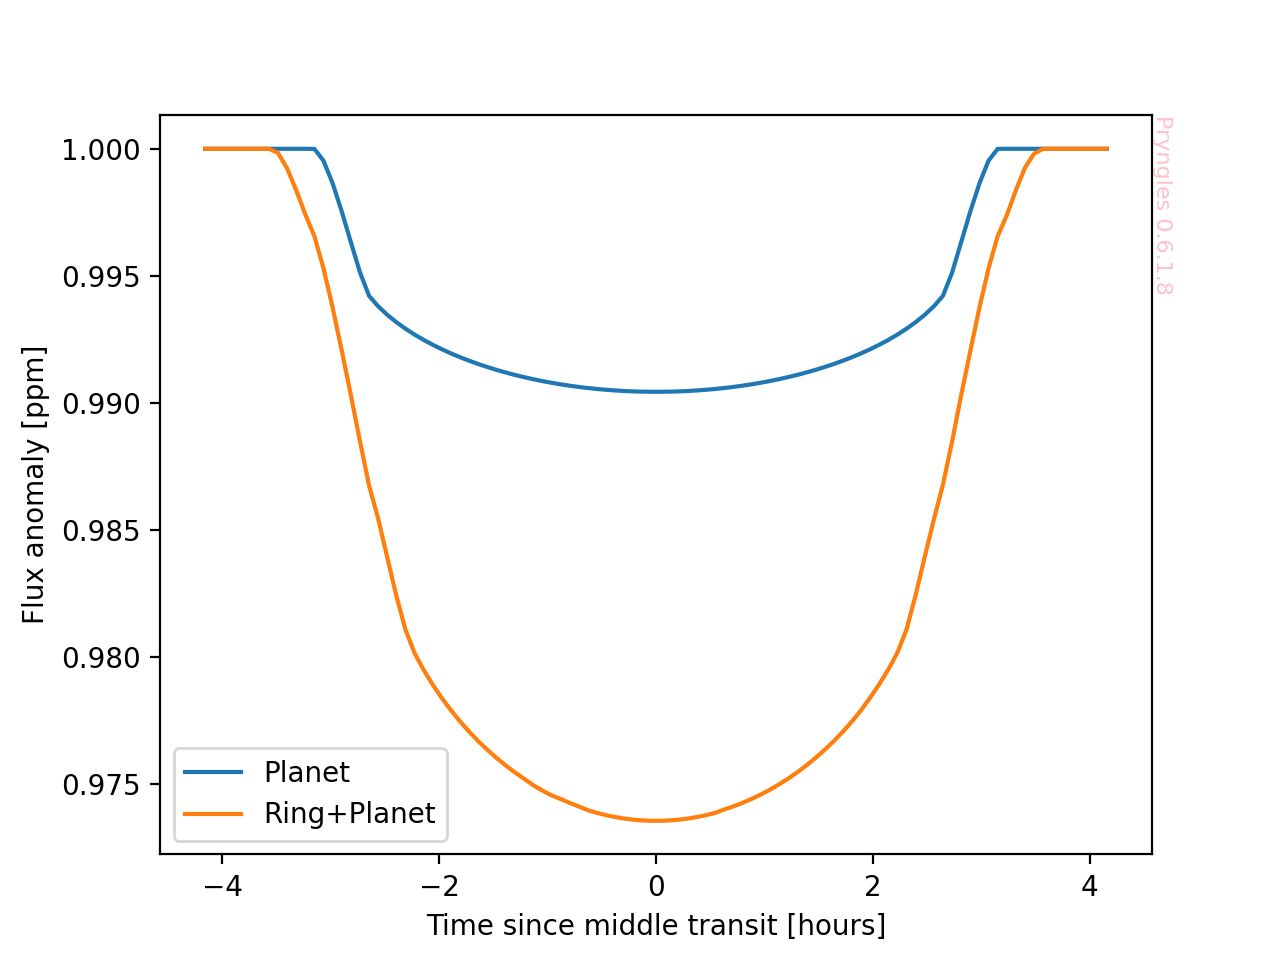

In [15]:
import numpy as np
RP.changeObserver([90.0*Consts.deg,0.0*Consts.deg])

lamb_initial=270*Consts.deg-RP.thetas-2*RP.fe*RP.thetap
lamb_final=270*Consts.deg+RP.thetas+2*RP.fe*RP.thetap
lambs=np.linspace(lamb_initial,lamb_final,100)
Tps=[]
Ts=[]
ts=[]
for lamb in lambs:
    RP.changeStellarPosition(lamb)
    #This attribute keeps the value of time
    t=RP.t*RP.CU.UT
    
    #Compute transit
    RP.updateOpticalFactors()
    RP.updateTransit()
    Tp=RP.Tip.sum()
    T=Tp+RP.Tir.sum()
    
    ts+=[t]
    Tps+=[Tp]
    Ts+=[T]
    
ts=np.array(ts)
Ts=np.array(Ts)
Tps=np.array(Tps)

#Middle transit
tmed=(ts[-1]+ts[0])/2
ts=(ts-tmed)/Consts.hr


#Plot
fig=plt.figure()
ax=fig.gca()    
ax.plot(ts,1-Tps,label="Planet")
ax.plot(ts,1-Ts,label="Ring+Planet")

ax.set_xlabel("Time since middle transit [hours]")
ax.set_ylabel("Flux anomaly [ppm]")
Extra.prynglesMark(ax)

ax.legend()

### Occultation light-curve

<IPython.core.display.Javascript object>


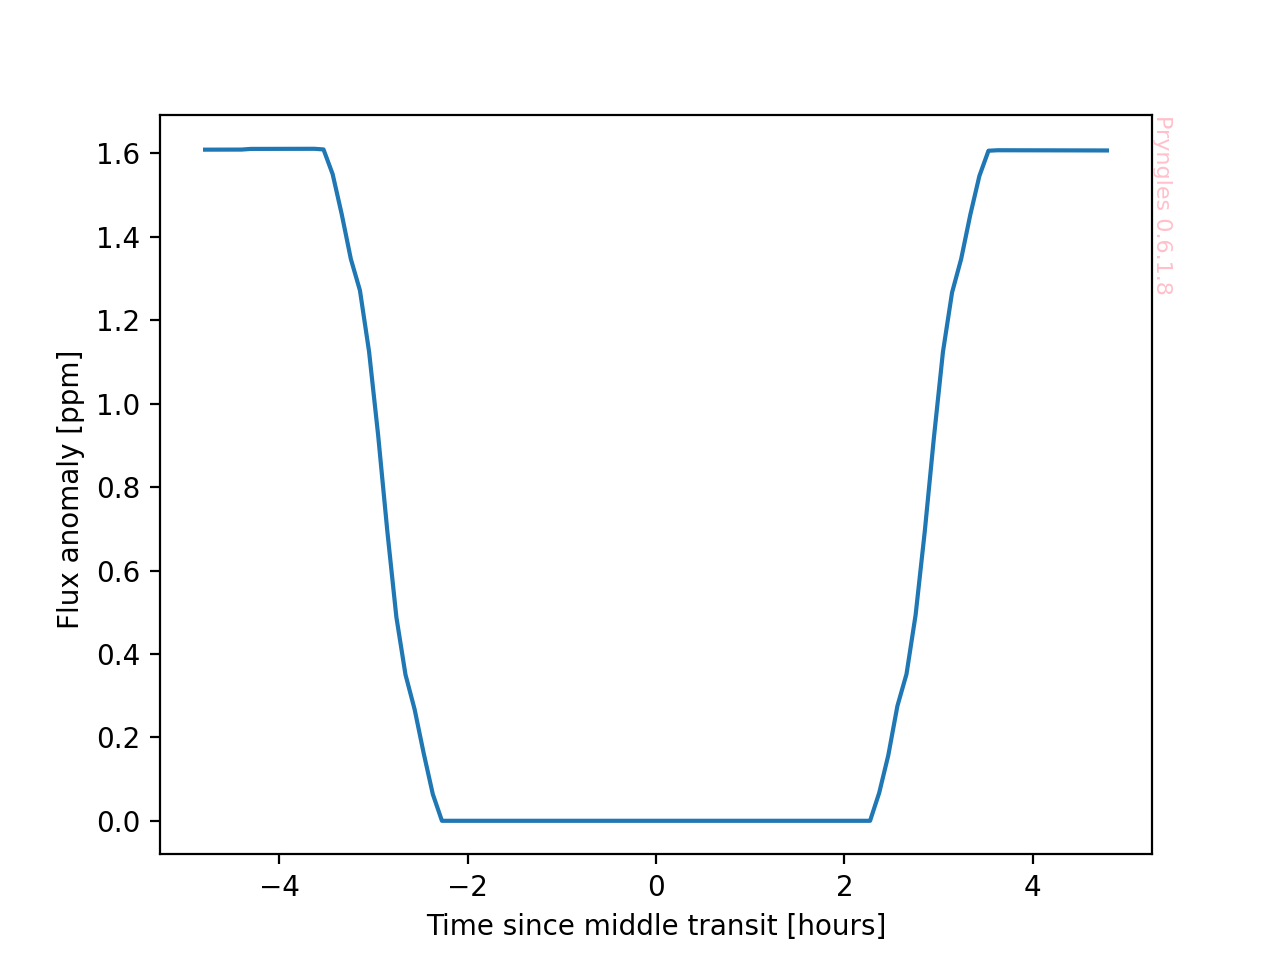

Text(1, 1, 'Pryngles 0.6.1.8')

In [13]:
import numpy as np
RP.changeObserver([90.0*Consts.deg,0.0*Consts.deg])

lamb_initial=+90.0*Consts.deg-(RP.thetas+3*RP.fe*RP.thetap)
lamb_final=+90.0*Consts.deg+(RP.thetas+3*RP.fe*RP.thetap)
lambs=np.linspace(lamb_initial,lamb_final,100)
Rs=[]
ts=[]
for lamb in lambs:
    RP.changeStellarPosition(lamb)
    #This attribute keeps the value of time
    t=RP.t*RP.CU.UT
    
    #Compute transit
    RP.updateOpticalFactors()
    RP.updateDiffuseReflection()
    
    ts+=[t]
    Rs+=[RP.Rip.sum()+RP.Rir.sum()]
    
ts=np.array(ts)
Rs=np.array(Rs)

#Middle transit
tmed=(ts[-1]+ts[0])/2
ts=(ts-tmed)/Consts.hr


#Plot
fig=plt.figure()
ax=fig.gca()    
ax.plot(ts,1e6*Rs)

ax.set_xlabel("Time since middle transit [hours]")
ax.set_ylabel("Flux anomaly [ppm] ")
Extra.prynglesMark(ax)

### Diffuse reflection light-curve


Let's compute a light-curve:

<IPython.core.display.Javascript object>


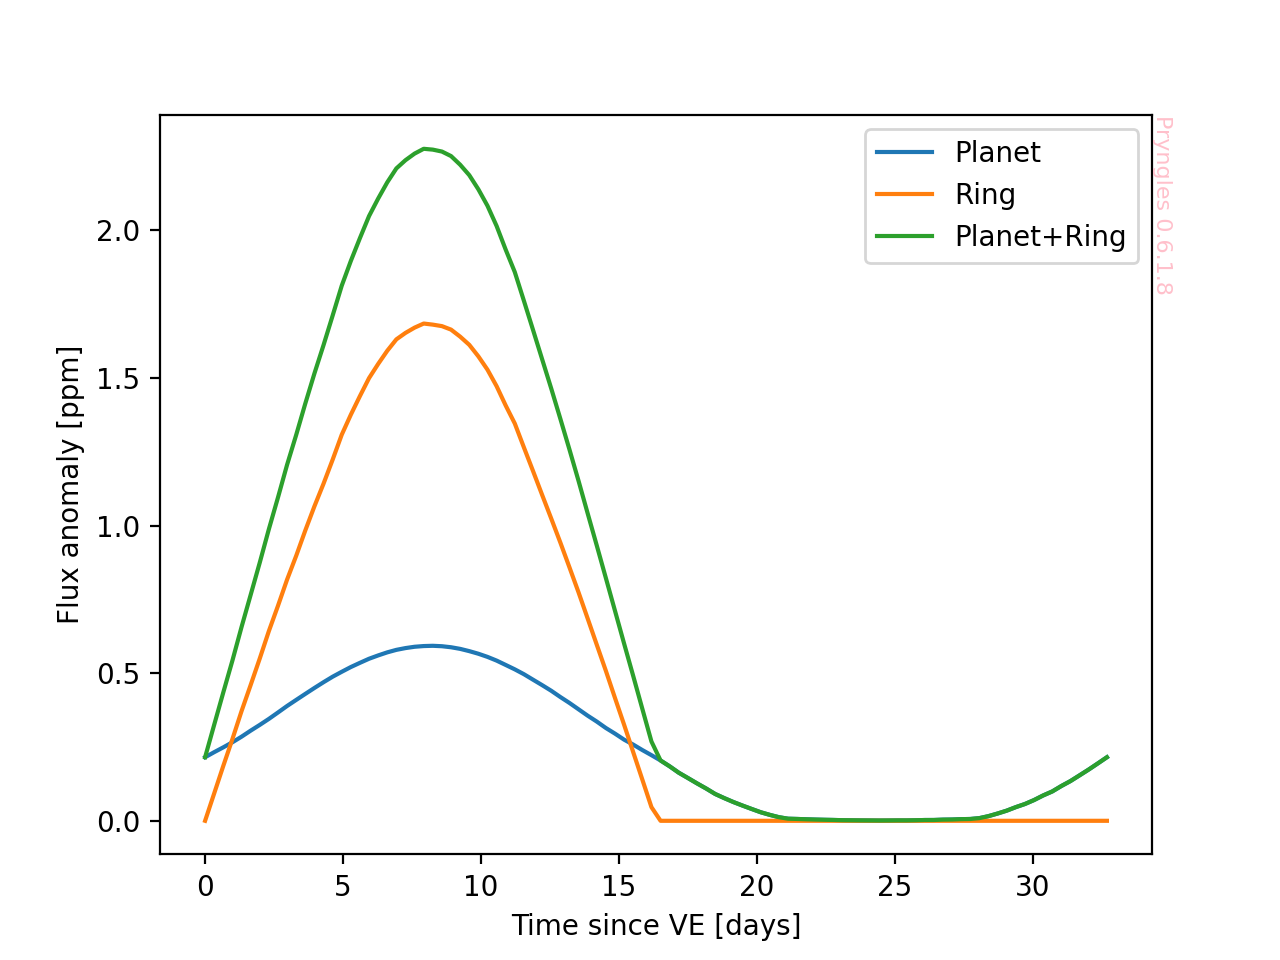

In [14]:
RP.changeObserver([90*Consts.deg,30*Consts.deg])

lamb_initial=+0.0*Consts.deg
lamb_final=+360*Consts.deg
lambs=np.linspace(lamb_initial,lamb_final,100)
Rps=[]
Rrs=[]
ts=[]
for lamb in lambs:
    RP.changeStellarPosition(lamb)
    ts+=[RP.t*RP.CU.UT]
    RP.updateOpticalFactors()
    RP.updateDiffuseReflection()
    Rps+=[RP.Rip.sum()]
    Rrs+=[RP.Rir.sum()]
    
ts=np.array(ts)
Rps=np.array(Rps)
Rrs=np.array(Rrs)

#Middle transit
ts=(ts-ts[0])/Consts.day

#Plot
fig=plt.figure()
ax=fig.gca()    
ax.plot(ts,1e6*Rps,label="Planet")
ax.plot(ts,1e6*Rrs,label="Ring")
ax.plot(ts,1e6*(Rps+Rrs),label="Planet+Ring")

ax.set_xlabel("Time since VE [days]")
ax.set_ylabel("Flux anomaly [ppm]")
Extra.prynglesMark(ax)

ax.legend();

Now you have the basics! Let's play and do some science!

--- 
*The authors*, Last update: july 19, 2022.